In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [5]:
df = pd.read_excel("owid-covid-data.xlsx", engine="openpyxl")

df.to_csv("owid-covid-data.csv", index=False)

In [6]:
df = pd.read_csv("owid-covid-data.csv", low_memory=False)

df.columns = df.columns.str.lower().str.strip()
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df = df[df["location"].notna()]
df = df.sort_values(["location", "date"])

In [7]:
for col in ["new_cases", "new_deaths", "new_tests", "new_vaccinations"]:
    if col in df.columns:
        df[col] = df[col].mask(df[col] < 0)

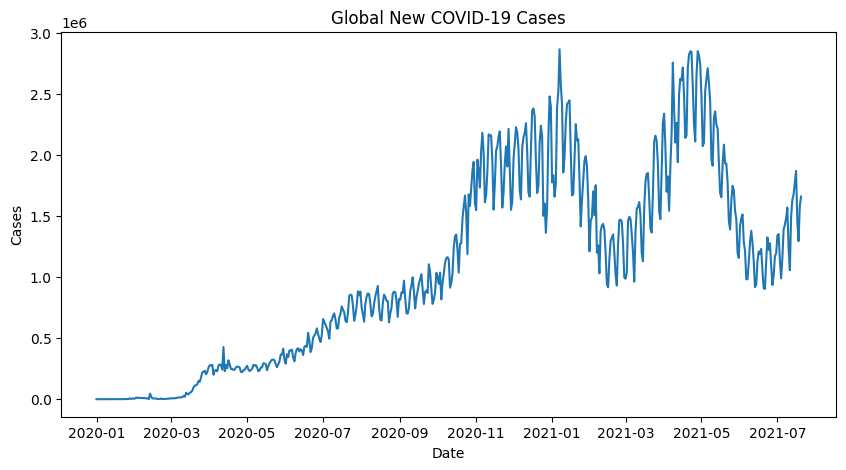

In [8]:
global_cases = df.groupby("date")["new_cases"].sum()

plt.figure(figsize=(10,5))
plt.plot(global_cases.index, global_cases.values)
plt.title("Global New COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

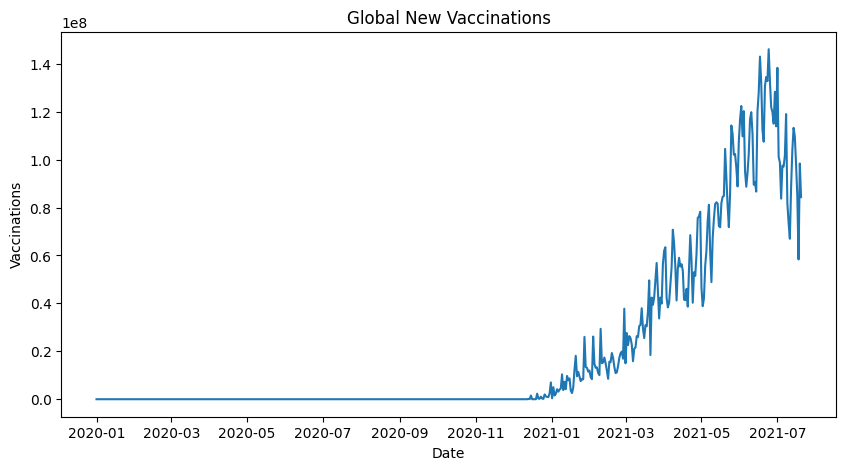

In [9]:
if "new_vaccinations" in df.columns:
    global_vacc = df.groupby("date")["new_vaccinations"].sum()

    plt.figure(figsize=(10,5))
    plt.plot(global_vacc.index, global_vacc.values)
    plt.title("Global New Vaccinations")
    plt.xlabel("Date")
    plt.ylabel("Vaccinations")
    plt.show()

In [10]:
df = df.dropna(subset=['new_cases', 'new_tests'])
df['positivity'] = df['new_cases'] / df['new_tests']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['positivity'])

In [11]:
def predict_positivity_rate(country, days=14):
    temp = df[df['location'] == country].copy()
    temp = temp.sort_values('date').dropna(subset=['positivity'])

    # Time index
    temp['t'] = np.arange(len(temp))

    model = LinearRegression()
    model.fit(temp['t'].values.reshape(-1,1), temp['positivity'].values)

    # Predict future
    future_t = np.arange(len(temp), len(temp)+days)
    future_pred = model.predict(future_t.reshape(-1,1))

    return temp, future_pred


🔮 Positivity Rate Prediction for India
Day 1: 0.06564
Day 2: 0.06564
Day 3: 0.06564
Day 4: 0.06564
Day 5: 0.06564
Day 6: 0.06563
Day 7: 0.06563
Day 8: 0.06563
Day 9: 0.06563
Day 10: 0.06563
Day 11: 0.06563
Day 12: 0.06563
Day 13: 0.06562
Day 14: 0.06562


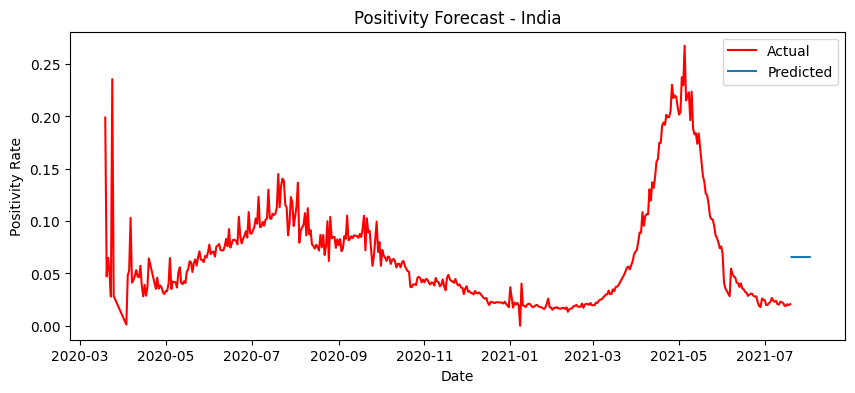


🔮 Positivity Rate Prediction for United States
Day 1: 0.04551
Day 2: 0.04541
Day 3: 0.04530
Day 4: 0.04520
Day 5: 0.04510
Day 6: 0.04500
Day 7: 0.04490
Day 8: 0.04479
Day 9: 0.04469
Day 10: 0.04459
Day 11: 0.04449
Day 12: 0.04439
Day 13: 0.04428
Day 14: 0.04418


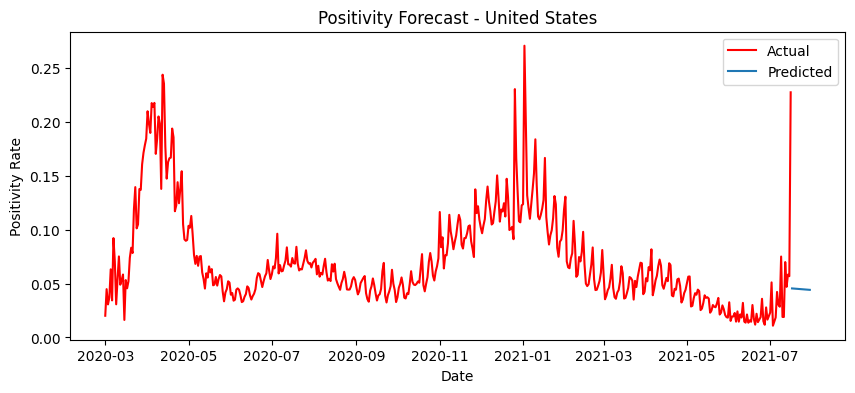

In [13]:
countries = ["India", "United States"]

for c in countries:
    temp, pred = predict_positivity_rate(c)

    print(f"\n🔮 Positivity Rate Prediction for {c}")
    for i, v in enumerate(pred, start=1):
        print(f"Day {i}: {v:.5f}")


    plt.figure(figsize=(10,4))
    plt.plot(temp["date"], temp["positivity"], label="Actual", color="red")

    future_dates = pd.date_range(
        start=temp['date'].max() + pd.Timedelta(days=1),
        periods=len(pred)
    )

    plt.plot(future_dates, pred, label="Predicted")
    plt.title(f"Positivity Forecast - {c}")
    plt.xlabel("Date")
    plt.ylabel("Positivity Rate")
    plt.legend()
    plt.show()